In [41]:
import json
import pandas as pd
import geopandas as gpd
from fuzzywuzzy import process, fuzz
from scipy import stats
%matplotlib inline

### Import et Traitement résultats Brevet

https://data.education.gouv.fr/explore/dataset/fr-en-dnb-par-etablissement/api/<br>
Filtrer sur session, public et departement
Exporter en CSV

In [2]:
# Import brevet.csv
brevet = pd.read_csv('input/resultats_brevet.csv', sep=";")

In [3]:
brevet[brevet['Session']==2021]

,Session,Numero d'etablissement,Type d'etablissement,Patronyme,Secteur d'enseignement,Commune,Libellé commune,Code département,Libellé département,Code académie,...,Code région,Libellé région,Inscrits,Presents,Admis,Admis sans mention,Nombre_d_admis_Mention_AB,Admis Mention bien,Admis Mention très bien,Taux de réussite
0,2021,0750478M,COLLEGE,JEAN-BAPTISTE CLEMENT,PUBLIC,75120,PARIS 20E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,98,97,82,18,18,16,30,"84,5%"
1,2021,0750550R,COLLEGE,LUCIE FAURE,PUBLIC,75120,PARIS 20E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,97,97,82,25,14,23,20,"84,5%"
2,2021,0750552T,COLLEGE,FRANCOISE DOLTO,PUBLIC,75120,PARIS 20E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,115,114,93,23,19,13,38,"81,6%"
3,2021,0750608D,COLLEGE,ANNE FRANK,PUBLIC,75111,PARIS 11E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,108,108,99,8,12,25,54,"91,7%"
4,2021,0751793S,COLLEGE,MAURICE UTRILLO,PUBLIC,75118,PARIS 18E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,91,91,77,23,21,15,18,"84,6%"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,2021,0752693V,COLLEGE,FRANCOIS COUPERIN,PUBLIC,75104,PARIS 4E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,110,110,100,6,16,27,51,"90,9%"
111,2021,0752957G,COLLEGE,GEORGES BRAQUE,PUBLIC,75113,PARIS 13E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,136,134,115,27,20,19,49,"85,8%"
112,2021,0753046D,COLLEGE,FLORA TRISTAN,PUBLIC,75120,PARIS 20E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,119,119,105,18,32,17,38,"88,2%"
113,2021,0753936W,COLLEGE,GERMAINE TILLION,PUBLIC,75112,PARIS 12E ARRONDISSEMENT,75,PARIS,1,...,10,ILE-DE-FRANCE,118,117,84,20,14,22,28,"71,8%"


In [4]:
# Import brevet.csv
brevet = pd.read_csv('input/resultats_brevet.csv', sep=";", 
                     usecols = 
                     ['Patronyme',
                    "Type d'etablissement",
                      "Numero d'etablissement",
                      'Inscrits',
                      'Presents',
                      'Admis',
                      'Admis sans mention'
                     ])

In [5]:
#Filtre sur les collèges et drop colonne, sort by nom
brevet = brevet[brevet["Type d'etablissement"] == 'COLLEGE'].sort_values(by='Patronyme')

In [6]:
brevet['Presents'] = pd.to_numeric(brevet['Presents'])
brevet['Admis'] = pd.to_numeric(brevet['Admis'])
brevet['Admis sans mention'] = pd.to_numeric(brevet['Admis sans mention'])

In [7]:
brevet['Taux de réussite'] = 100 * brevet['Admis'] / brevet['Presents']
brevet['Taux de mention'] = 100 * (brevet['Admis'] - brevet['Admis sans mention']) / brevet['Presents']

In [8]:
# Suppression % sur les taux de reussite
brevet.loc[:, 'Taux de réussite'] = brevet.loc[:, 'Taux de réussite'].apply(lambda tx : round(tx,1))
brevet.loc[:, 'Taux de mention'] = brevet.loc[:, 'Taux de mention'].apply(lambda tx : round(tx,1))

In [9]:
# Changement du nom de la colonne numero d'etab en code pour mapping plus tard
brevet = brevet.rename(columns={"Numero d'etablissement": 'code'})

In [10]:
brevet.head()

,code,Type d'etablissement,Patronyme,Inscrits,Presents,Admis,Admis sans mention,Taux de réussite,Taux de mention
22,0755433Y,COLLEGE,AIMÉ CÉSAIRE,98,98,57,22,58.2,35.7
75,0750607C,COLLEGE,ALAIN FOURNIER,153,153,144,30,94.1,74.5
97,0750445B,COLLEGE,ALBERTO GIACOMETTI,124,124,101,26,81.5,60.5
54,0751705W,COLLEGE,ALPHONSE DAUDET,112,112,104,15,92.9,79.5
21,0754305X,COLLEGE,ANDRE CITROEN,149,144,131,20,91.0,77.1


### Import liste établissements
https://opendata.paris.fr/explore/dataset/etablissements-scolaires-colleges/information/?disjunctive.id_projet&disjunctive.arr_libelle&disjunctive.arr_insee<br>
Filtrer sur code colleges (3482 pour 2018)<br>
Exporter en shapefile <br>
Copier les quatre fichiers dans input

In [149]:
#Import fichier
colleges = gpd.read_file('input/etablissements-scolaires-colleges.shp',encoding = 'utf-8')

In [150]:
colleges.head()

,id_projet,libelle,adresse,arr_libelle,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry
0,COLLEGES (année scolaire 2023/2024),ROSE BLANCHE,101 RUE DE SAUSSURE,17ème Ardt,75117,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31004 48.88934)
1,COLLEGES (année scolaire 2023/2024),STEPHANE MALLARME,29 RUE DE LA JONQUIERE,17ème Ardt,75117,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32448 48.89348)
2,COLLEGES (année scolaire 2023/2024),CHAPTAL,45 BOULEVARD DES BATIGNOLLES,8ème Ardt,75108,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31969 48.88174)
3,COLLEGES (année scolaire 2023/2024),CESAR FRANCK,5 RUE DE LA JUSSIENNE,2ème Ardt,75102,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.34420 48.86536)
4,COLLEGES (année scolaire 2023/2024),BERNARD PALISSY,21 RUE DES PETITS HOTELS,10ème Ardt,75110,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.35286 48.87746)


In [151]:
#Verification taille (115 attendu)
colleges.loc[:,'id_projet'].size

114

In [152]:
# On vire colonnes inutiles
colleges.drop(['id_projet','arr_libelle'],axis=1, inplace=True)

In [153]:
# Adresse en majuscule
colleges.loc[:,'adresse'] = colleges.loc[:,'adresse'].apply(lambda ad : ad.upper())

In [154]:
# On clean arr_insee
colleges['arr_insee'] = colleges['arr_insee'].astype(str)
colleges.loc[:,'arr_insee'] = colleges.loc[:,'arr_insee'].apply(lambda arr : arr.replace(".0","").replace("751","750"))

In [155]:
colleges.head()

,libelle,adresse,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry
0,ROSE BLANCHE,101 RUE DE SAUSSURE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31004 48.88934)
1,STEPHANE MALLARME,29 RUE DE LA JONQUIERE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32448 48.89348)
2,CHAPTAL,45 BOULEVARD DES BATIGNOLLES,75008,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31969 48.88174)
3,CESAR FRANCK,5 RUE DE LA JUSSIENNE,75002,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.34420 48.86536)
4,BERNARD PALISSY,21 RUE DES PETITS HOTELS,75010,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.35286 48.87746)


In [156]:
# On ajoute les colonnes lat et lng (pour plus tard dans la creation du json)
colleges['lng'] = colleges['geometry'].apply(lambda z:z.xy[0][0])
colleges['lat'] = colleges['geometry'].apply(lambda z:z.xy[1][0])

### Recuperation des codes à partir de la table de mapping colleges_code.csv

In [157]:
# Load les codes etablissements
codes = pd.read_csv("input/colleges_code.csv",sep=";")

In [158]:
# On ajoute le code au df colleges
colleges = pd.merge(colleges, codes, how='left', on='libelle')

In [159]:
# On checke s'il ya des NaN (en théorie aucun)
colleges[colleges['code'].isnull()]

,libelle,adresse,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry,lng,lat,code,colzone


In [160]:
colleges.head()

,libelle,adresse,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry,lng,lat,code,colzone
0,ROSE BLANCHE,101 RUE DE SAUSSURE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31004 48.88934),2.310037,48.889335,0755779Z,#ccebc5
1,STEPHANE MALLARME,29 RUE DE LA JONQUIERE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32448 48.89348),2.324482,48.893482,0752554U,#b3de69
2,CHAPTAL,45 BOULEVARD DES BATIGNOLLES,75008,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31969 48.88174),2.319688,48.881738,0752529S,#ccebc5
3,CESAR FRANCK,5 RUE DE LA JUSSIENNE,75002,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.34420 48.86536),2.344203,48.865356,0752248L,#fdb462
4,BERNARD PALISSY,21 RUE DES PETITS HOTELS,75010,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.35286 48.87746),2.352859,48.877463,0752829T,#80b1d3


### Taux de réussite au brevet

In [161]:
colleges = pd.merge(colleges, brevet[['code','Taux de mention','Taux de réussite']], how='left', on='code')

In [162]:
# On checke s'il ya des NaN (quelques uns)
colleges[colleges['Taux de mention'].isnull()]

,libelle,adresse,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry,lng,lat,code,colzone,Taux de mention,Taux de réussite


In [163]:
# on remplace les null par 999
colleges.fillna(999, inplace=True)

### Percentiles et couleurs

In [164]:
# généré via https://colordesigner.io/gradient-generator 
grad_cols = [
'#FAEB6E',
'#E0E46D',
'#C7DC6D',
'#AFD46F',
'#98CB71',
'#82C273',
'#6DB876',
'#5AAE77',
'#47A378',
'#369979',
'#258E78',
'#168375',
'#087872',
'#026D6D',
'#056267',
'#0C5760',
'#124C57',
'#17424D',
'#193843',
'#1A2E38'
]

In [169]:
def taux_to_color(taux, taux_series):
    rank = stats.percentileofscore(taux_series, taux, kind='weak')
    #print(rank)
    color = grad_cols[int((rank-0.001) / 5)]
    return color

In [172]:
colleges.loc[:,'colreu'] = colleges.loc[:,'Taux de réussite'].apply(lambda tx : taux_to_color(tx, colleges['Taux de réussite']))
colleges.loc[:,'colmention'] = colleges.loc[:,'Taux de mention'].apply(lambda tx : taux_to_color(tx, colleges['Taux de mention']))

In [173]:
colleges.head()

,libelle,adresse,arr_insee,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry,lng,lat,code,colzone,Taux de mention,Taux de réussite,colreu,colmention
0,ROSE BLANCHE,101 RUE DE SAUSSURE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31004 48.88934),2.310037,48.889335,0755779Z,#ccebc5,53.7,78.7,#C7DC6D,#E0E46D
1,STEPHANE MALLARME,29 RUE DE LA JONQUIERE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32448 48.89348),2.324482,48.893482,0752554U,#b3de69,66.0,79.6,#AFD46F,#5AAE77
2,CHAPTAL,45 BOULEVARD DES BATIGNOLLES,75008,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31969 48.88174),2.319688,48.881738,0752529S,#ccebc5,91.7,96.7,#193843,#193843
3,CESAR FRANCK,5 RUE DE LA JUSSIENNE,75002,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.34420 48.86536),2.344203,48.865356,0752248L,#fdb462,80.5,91.5,#087872,#026D6D
4,BERNARD PALISSY,21 RUE DES PETITS HOTELS,75010,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.35286 48.87746),2.352859,48.877463,0752829T,#80b1d3,75.6,88.5,#369979,#168375


### Changement noms de colonnes pour matcher code js

In [174]:
colleges = colleges.rename(columns={'libelle': 'nom', 'arr_insee':'codepostal','Taux de mention':'txmention','Taux de réussite':'txreu'})

In [175]:
colleges

,nom,adresse,codepostal,annee_scol,type_etabl,created_use,created_dat,last_edited,geometry,lng,lat,code,colzone,txmention,txreu,colreu,colmention
0,ROSE BLANCHE,101 RUE DE SAUSSURE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31004 48.88934),2.310037,48.889335,0755779Z,#ccebc5,53.7,78.7,#C7DC6D,#E0E46D
1,STEPHANE MALLARME,29 RUE DE LA JONQUIERE,75017,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32448 48.89348),2.324482,48.893482,0752554U,#b3de69,66.0,79.6,#AFD46F,#5AAE77
2,CHAPTAL,45 BOULEVARD DES BATIGNOLLES,75008,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.31969 48.88174),2.319688,48.881738,0752529S,#ccebc5,91.7,96.7,#193843,#193843
3,CESAR FRANCK,5 RUE DE LA JUSSIENNE,75002,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.34420 48.86536),2.344203,48.865356,0752248L,#fdb462,80.5,91.5,#087872,#026D6D
4,BERNARD PALISSY,21 RUE DES PETITS HOTELS,75010,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.35286 48.87746),2.352859,48.877463,0752829T,#80b1d3,75.6,88.5,#369979,#168375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,LA GRANGE AUX BELLES,158 QUAI DE JEMMAPES,75010,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.36663 48.87799),2.366635,48.877985,0753047E,#fccde5,61.4,82.9,#6DB876,#82C273
110,DANIEL MAYER,2 PLACE HEBERT,75018,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.36386 48.89314),2.363862,48.893141,0755030K,#fb8072,58.1,85.1,#5AAE77,#C7DC6D
111,ALPHONSE DAUDET,93 RUE D' ALESIA,75014,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.32591 48.82801),2.325909,48.828012,0751705W,#fccde5,79.5,92.9,#056267,#087872
112,GUILLAUME APOLLINAIRE,39 AVENUE EMILE ZOLA,75015,2023-2024,Collège,LECOQH,2023-03-16 15:02:54+01:00,2023-03-16 15:02:54+01:00,POINT (2.28268 48.84657),2.282680,48.846571,0752190Y,#ffffb3,57.0,75.6,#E0E46D,#C7DC6D


In [176]:
colleges['colreu'].value_counts()

#17424D    7
#C7DC6D    6
#0C5760    6
#193843    6
#087872    6
#369979    6
#168375    6
#98CB71    6
#6DB876    6
#1A2E38    6
#5AAE77    6
#47A378    6
#056267    6
#E0E46D    6
#258E78    5
#AFD46F    5
#82C273    5
#FAEB6E    5
#026D6D    5
#124C57    4
Name: colreu, dtype: int64

### Creation d'un dictionnaire colleges

In [177]:
coll_dict = {} 
for index, row in colleges.iterrows():
    coll_dict[row['code']] = {}
    coll_dict[row['code']]['nom'] = row['nom']
    coll_dict[row['code']]['adresse'] = row['adresse']
    coll_dict[row['code']]['codepostal'] = row['codepostal']
    coll_dict[row['code']]['lng'] = row['lng']
    coll_dict[row['code']]['lat'] = row['lat']
    coll_dict[row['code']]['txmention'] = row['txmention']
    coll_dict[row['code']]['colmention'] = row['colmention']
    coll_dict[row['code']]['txreu'] = row['txreu']
    coll_dict[row['code']]['colreu'] = row['colreu']
    coll_dict[row['code']]['colzone'] = row['colzone']

In [178]:
# Export colleges_data.json
with open('output/colleges_data.json', 'w') as fp:
    json.dump(coll_dict, fp)

### Export colleges.geojson

In [119]:
colleges.drop(labels=['adresse','codepostal','lng','lat','txmention','txreu','colzone','colreu','colmention'],axis = 1).to_file('output/colleges.geojson', driver="GeoJSON")

C:\Users\jcourbage\Anaconda3\envs\cartescolaire\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Import sectorisation
https://opendata.paris.fr/explore/dataset/secteurs-scolaires/?refine.id_projet=3482 <br>
https://opendata.paris.fr/explore/dataset/secteurs-scolaires-colleges/information/?disjunctive.id_projet&disjunctive.zone_commune&disjunctive.annee_scol<br>
Filtrer sur type etab (3482 pour 2017-2018)
Exporter en shapefile <br>
Copier les quatre fichiers dans input

In [33]:
secto = gpd.read_file('input/secteurs-scolaires-colleges.shp',encoding = 'utf-8')

In [34]:
secto.head()

,id_projet,libelle,annee_scol,zone_commun,etiquette,lib_etab_1,lib_etab_2,lib_etab_3,lib_etab_4,adr_etab_1,adr_etab_2,adr_etab_3,adr_etab_4,st_area_sha,st_perimete,type_etabl,geometry
0,COLLEGES (année scolaire 2023/2024),FRANCOISE DOLTO,2023-2024,0,Secteur du collège FRANCOISE DOLTO,FRANCOISE DOLTO,None,None,None,354 RUE DES PYRENEES,None,None,None,316423.126157,14361.508217,Collège,"MULTIPOLYGON (((2.38554 48.87371, 2.38568 48.8..."
1,COLLEGES (année scolaire 2023/2024),THOMAS MANN,2023-2024,0,Secteur du collège THOMAS MANN,THOMAS MANN,None,None,None,91 AVENUE DE FRANCE,None,None,None,726501.080130,28117.774469,Collège,"MULTIPOLYGON (((2.38566 48.82410, 2.38580 48.8..."
2,COLLEGES (année scolaire 2023/2024),AIME CESAIRE,2023-2024,0,Secteur du collège AIME CESAIRE,AIME CESAIRE,None,None,None,22 RUE PAJOL,None,None,None,334450.972963,11538.987331,Collège,"MULTIPOLYGON (((2.36668 48.88973, 2.36679 48.8..."
3,COLLEGES (année scolaire 2023/2024),ANDRE MALRAUX,2023-2024,0,Secteur du collège ANDRE MALRAUX,ANDRE MALRAUX,None,None,None,5 bis RUE SAINT-FERDINAND,None,None,None,510288.754858,24663.363187,Collège,"MULTIPOLYGON (((2.28482 48.88508, 2.28482 48.8..."
4,COLLEGES (année scolaire 2023/2024),PIERRE DE RONSARD,2023-2024,0,Secteur du collège PIERRE DE RONSARD,PIERRE DE RONSARD,None,None,None,140 AVENUE DE WAGRAM,None,None,None,536218.895586,28133.513287,Collège,"MULTIPOLYGON (((2.29678 48.88967, 2.29701 48.8..."


## Liste des secteurs avec plusieurs colleges (en theorie 3)

In [35]:
secto[secto['zone_commun'] == 1]

,id_projet,libelle,annee_scol,zone_commun,etiquette,lib_etab_1,lib_etab_2,lib_etab_3,lib_etab_4,adr_etab_1,adr_etab_2,adr_etab_3,adr_etab_4,st_area_sha,st_perimete,type_etabl,geometry


In [36]:
# On supprime tout de suite les colonnes qui ne nous serviront à rien
secto.drop(['id_projet',
            'zone_commun',
            'annee_scol',
            'adr_etab_1',
            'adr_etab_2',
            'adr_etab_3',
            'adr_etab_4'],
           axis=1, inplace=True)

In [37]:
secto.head()

,libelle,etiquette,lib_etab_1,lib_etab_2,lib_etab_3,lib_etab_4,st_area_sha,st_perimete,type_etabl,geometry
0,FRANCOISE DOLTO,Secteur du collège FRANCOISE DOLTO,FRANCOISE DOLTO,None,None,None,316423.126157,14361.508217,Collège,"MULTIPOLYGON (((2.38554 48.87371, 2.38568 48.8..."
1,THOMAS MANN,Secteur du collège THOMAS MANN,THOMAS MANN,None,None,None,726501.080130,28117.774469,Collège,"MULTIPOLYGON (((2.38566 48.82410, 2.38580 48.8..."
2,AIME CESAIRE,Secteur du collège AIME CESAIRE,AIME CESAIRE,None,None,None,334450.972963,11538.987331,Collège,"MULTIPOLYGON (((2.36668 48.88973, 2.36679 48.8..."
3,ANDRE MALRAUX,Secteur du collège ANDRE MALRAUX,ANDRE MALRAUX,None,None,None,510288.754858,24663.363187,Collège,"MULTIPOLYGON (((2.28482 48.88508, 2.28482 48.8..."
4,PIERRE DE RONSARD,Secteur du collège PIERRE DE RONSARD,PIERRE DE RONSARD,None,None,None,536218.895586,28133.513287,Collège,"MULTIPOLYGON (((2.29678 48.88967, 2.29701 48.8..."


In [38]:
#On renomme lib_etab en nom

secto = secto.rename(columns={'lib_etab_1': 'nom1', 'lib_etab_2': 'nom2','lib_etab_3': 'nom3','lib_etab_4': 'nom4'})



In [37]:
#Cosmétique : on enlève Secteur du collège et Secteur des collèges
#secto.loc[:,'etiquette'] = secto.loc[:,'etiquette'].apply(lambda arr : arr.replace("Secteur du collège ","").replace("Secteur des collèges ",""))

In [39]:
# On ajoute nb etab et on compte le nombre de'tab par secteurs
secto['nbetab'] = 0
secto['nbetab'] = secto[['nom1', 'nom2', 'nom3', 'nom4']].apply(lambda x: sum(x.notnull()), axis=1)

In [40]:
secto[secto['nbetab']==2]

,libelle,etiquette,nom1,nom2,nom3,nom4,st_area_sha,st_perimete,type_etabl,geometry,nbetab
53,SMC CURIE / PHILIPPE,Secteur commun des collèges \nMARIE CURIE \nGE...,MARIE CURIE,GERARD PHILIPE,None,None,626262.936604,28865.587425,Collège,"MULTIPOLYGON (((2.35266 48.89818, 2.35366 48.8...",2
77,SMC BERGSON / PAILLERON,Secteur commun des collèges \nHENRI BERGSON \n...,HENRI BERGSON,EDOUARD PAILLERON,None,None,518821.040226,21923.682273,Collège,"MULTIPOLYGON (((2.38045 48.88232, 2.38054 48.8...",2
95,SMC BERLIOZ / COYSEVOX,Secteur commun des collèges \nHECTOR BERLIOZ \...,HECTOR BERLIOZ,ANTOINE COYSEVOX,None,None,625717.525335,29651.015253,Collège,"MULTIPOLYGON (((2.33388 48.89931, 2.33390 48.8...",2


In [40]:
# on splitte les multi secteurs - deprecated ?
#secto.loc[:,'nom1'] = secto.loc[:,'etiquette'].apply(lambda lib : lib.split("/")[0].strip())
#secto.loc[:,'nom2'] = secto.loc[:,'etiquette'].apply(lambda lib : lib.split("/")[1].strip() if (len(lib.split("/")) > 1) else "")
#secto.loc[:,'nom3'] = secto.loc[:,'etiquette'].apply(lambda lib : lib.split("/")[2].strip() if (len(lib.split("/")) > 2) else "")
#secto.loc[:,'nom4'] = secto.loc[:,'etiquette'].apply(lambda lib : lib.split("/")[3].strip() if (len(lib.split("/")) > 3) else "")

In [41]:
# On duplique colleges ... pas très joli mais pas mieux
colleges1 = colleges[['nom','code']].rename(columns={'nom': 'nom1','code':'code1'})
colleges2 = colleges[['nom','code']].rename(columns={'nom': 'nom2','code':'code2'})
colleges3 = colleges[['nom','code']].rename(columns={'nom': 'nom3','code':'code3'})
colleges4 = colleges[['nom','code']].rename(columns={'nom': 'nom4','code':'code4'})

In [42]:
#on merge avec les infos collèges
secto = pd.merge(secto, colleges1, how = 'left', left_on = 'nom1', right_on = 'nom1')
secto = pd.merge(secto, colleges2, how = 'left', left_on = 'nom2', right_on = 'nom2')
secto = pd.merge(secto, colleges3, how = 'left', left_on = 'nom3', right_on = 'nom3')
secto = pd.merge(secto, colleges4, how = 'left', left_on = 'nom4', right_on = 'nom4')

In [43]:
# on droppe etiquette et libelle (plus besoin)
secto.drop('etiquette',axis=1, inplace=True)
secto.drop('libelle',axis=1, inplace=True)

In [44]:
# On réordonne un peu
colonnes = ['nbetab',
            'nom1',
            'code1',
            'nom2',
            'code2',
            'nom3',
            'code3',
            'nom4',
            'code4',
            'geometry'
           ]

secto = secto[colonnes]

In [45]:
secto.head()

,nbetab,nom1,code1,nom2,code2,nom3,code3,nom4,code4,geometry
0,1,FRANCOISE DOLTO,0750552T,None,NaN,None,NaN,None,NaN,"MULTIPOLYGON (((2.38554 48.87371, 2.38568 48.8..."
1,1,THOMAS MANN,0755000C,None,NaN,None,NaN,None,NaN,"MULTIPOLYGON (((2.38566 48.82410, 2.38580 48.8..."
2,1,AIME CESAIRE,0755433Y,None,NaN,None,NaN,None,NaN,"MULTIPOLYGON (((2.36668 48.88973, 2.36679 48.8..."
3,1,ANDRE MALRAUX,0752387M,None,NaN,None,NaN,None,NaN,"MULTIPOLYGON (((2.28482 48.88508, 2.28482 48.8..."
4,1,PIERRE DE RONSARD,0752107H,None,NaN,None,NaN,None,NaN,"MULTIPOLYGON (((2.29678 48.88967, 2.29701 48.8..."


### Export sectorisation (full) - sans simplification

In [46]:
secto.to_file('output/secto_col_full.geojson', driver="GeoJSON")

C:\Users\jcourbage\Anaconda3\envs\cartescolaire\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Simplification
http://mapshaper.org/ <br>
Charger secto_col_full.geojson avec Snap vertices<br>
Repair line intersections <br>
Simplify jusqu'à 10% <br>
Export (shp) <br>
Copier les fichiers dans simplified

In [47]:
# On charge la secto simplifiée
secto_simp = gpd.read_file('simplified/secto_col_full.shp',encoding = 'utf-8')

In [48]:
# export geojson
secto_simp.to_file('output/secteurs_col.geojson', driver="GeoJSON")

C:\Users\jcourbage\Anaconda3\envs\cartescolaire\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Buffering

In [49]:
secto_buff = secto_simp.copy()

In [50]:
secto_buff.geometry = secto_buff['geometry'].buffer(0.0002,2).buffer(-0.0002,2)

C:\Users\jcourbage\AppData\Local\Temp\ipykernel_1932\1057994246.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  secto_buff.geometry = secto_buff['geometry'].buffer(0.0002,2).buffer(-0.0002,2)
C:\Users\jcourbage\AppData\Local\Temp\ipykernel_1932\1057994246.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  secto_buff.geometry = secto_buff['geometry'].buffer(0.0002,2).buffer(-0.0002,2)


<AxesSubplot:>

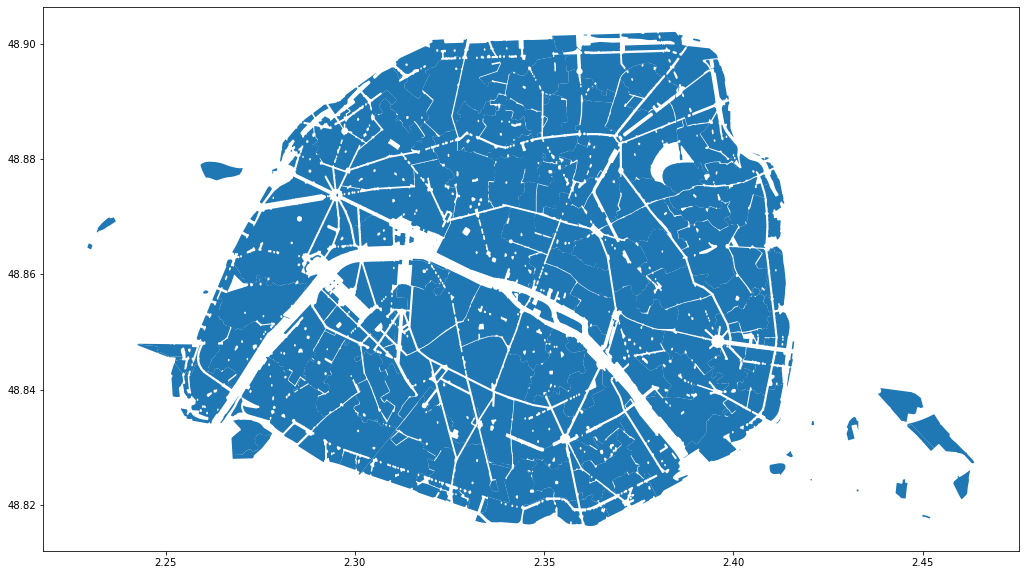

In [51]:
secto_buff.plot(figsize=(20,10))

<AxesSubplot:>

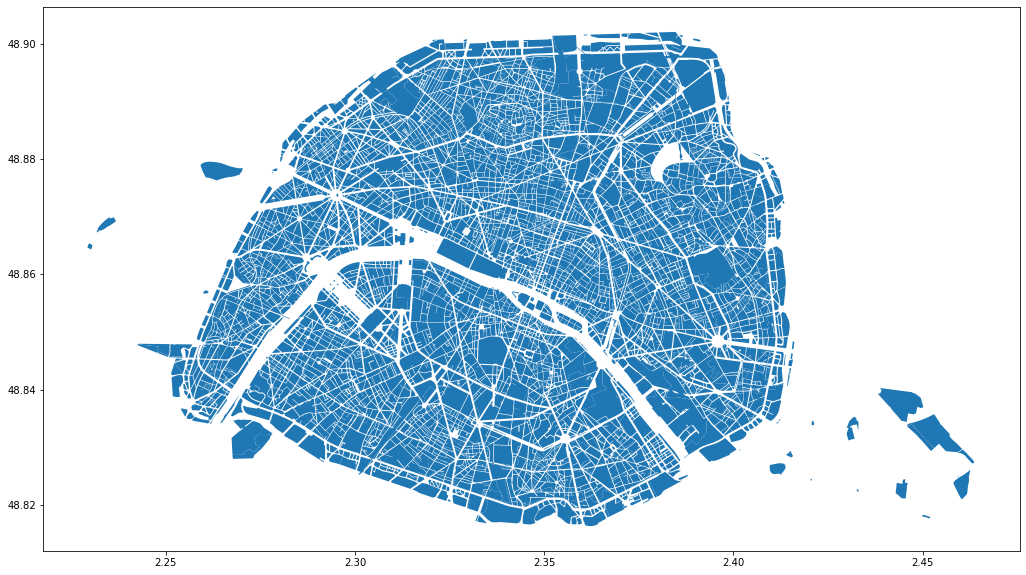

In [52]:
secto_simp.plot(figsize=(20,10))

<AxesSubplot:>

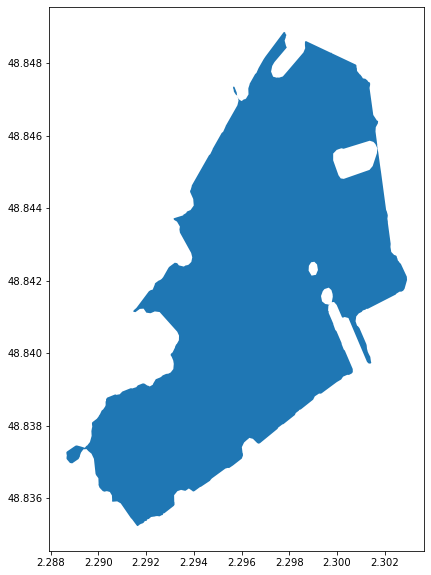

In [53]:
secto_buff[secto_buff['nom1']=='CAMILLE SEE'].plot(figsize=(20,10))

<AxesSubplot:>

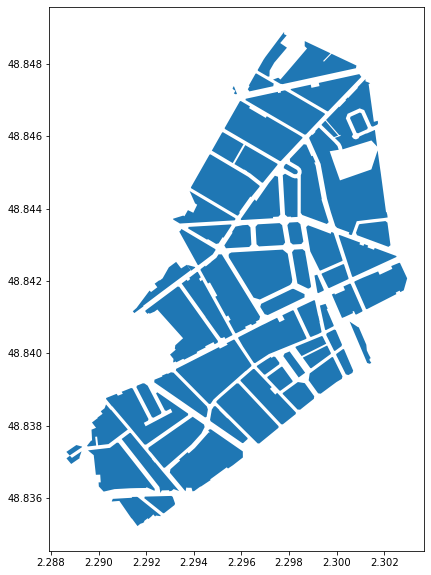

In [54]:
secto_simp[secto_simp['nom1']=='CAMILLE SEE'].plot(figsize=(20,10))

In [55]:
secto_buff.to_file('output/secteurs_col_light.geojson', driver="GeoJSON")

C:\Users\jcourbage\Anaconda3\envs\cartescolaire\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Lycées

donnees : https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/table/?disjunctive.nature_uai&disjunctive.nature_uai_libe&disjunctive.code_departement&disjunctive.code_region&disjunctive.code_academie&disjunctive.secteur_prive_code_type_contrat&disjunctive.secteur_prive_libelle_type_contrat&disjunctive.code_ministere&disjunctive.libelle_ministere&refine.localite_acheminement_uai=PARIS&refine.nature_uai_libe=LYCEE+D+ENSEIGNEMENT+GENERAL&refine.nature_uai_libe=LYCEE+ENSEIGNT+GENERAL+ET+TECHNOLOGIQUE&refine.nature_uai_libe=LYCEE+PROFESSIONNEL&refine.nature_uai_libe=LYCEE+POLYVALENT&refine.nature_uai_libe=LYCEE+D+ENSEIGNEMENT+TECHNOLOGIQUE

Telecharger en geojson

Remplacer data/lycees.geojson

In [1]:
# donnees : https://data.education.gouv.fr/explore/dataset/fr-en-adresse-et-geolocalisation-etablissements-premier-et-second-degre/table/?disjunctive.nature_uai&disjunctive.nature_uai_libe&disjunctive.code_departement&disjunctive.code_region&disjunctive.code_academie&disjunctive.secteur_prive_code_type_contrat&disjunctive.secteur_prive_libelle_type_contrat&disjunctive.code_ministere&disjunctive.libelle_ministere&refine.localite_acheminement_uai=PARIS&refine.nature_uai_libe=LYCEE+D+ENSEIGNEMENT+GENERAL&refine.nature_uai_libe=LYCEE+ENSEIGNT+GENERAL+ET+TECHNOLOGIQUE&refine.nature_uai_libe=LYCEE+PROFESSIONNEL&refine.nature_uai_libe=LYCEE+POLYVALENT&refine.nature_uai_libe=LYCEE+D+ENSEIGNEMENT+TECHNOLOGIQUE
